In [72]:
import numpy as np
import matplotlib.pyplot as plt

from module.utils import *

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

from ray import train, tune
from ray.train import Checkpoint, session, report
from ray.tune.schedulers import ASHAScheduler

import os
import tempfile

from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

In [73]:
# Set the directory containing the images
input_directory = 'data'

transform = transforms.Compose([transforms.ToTensor()])

# Create the dataset
dataset = datasets.DatasetFolder(input_directory,  transform=transform,  loader=npy_loader,  extensions=['.npy'])

# Get the class labels and split the dataset into train and test sets
class_labels = dataset.classes
train_dataset, test_dataset = train_test_split(dataset, test_size=0.20, random_state=42)

# Print the number of samples in each split
print("Train set size:", len(train_dataset))
print("Test set size:", len(test_dataset))

# Create data loaders
batch_size = 24 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train set size: 102
Test set size: 26


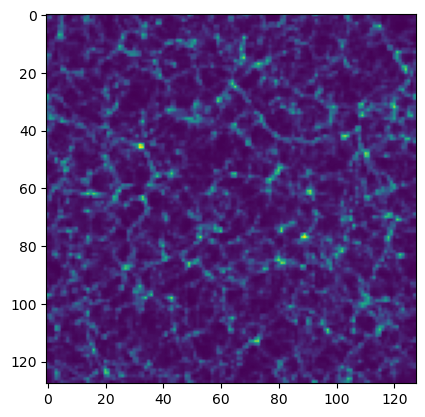

In [74]:
# show one image from the first batch
plt.figure()
plt.imshow(train_dataset[0][0][0])  

In [75]:
# define the model
# this is a VAE model
# for the encoder, two Conv2d layers are used to extract features from the input image
# the output image is of size 1x128X128
# first have 32 filters and kernel size 4, stride 2, padding 1
# second have 64 filters and kernel size 4, stride 2, padding 1
# then the output is flattened 
# then  n_dense number of dense layers with n_hidden units
# the latent space is represented by two vectors, mean and logvar, dimension latent_dim

# for the decoder, the latent space is first passed through a n_dense number of dense layers with n_hidden units
# then the output is reshaped 
# two ConvTranspose2d layers are used to reconstruct the image
# the output image is of size 1x128X128

class VAE(torch.nn.Module):
    def __init__(self,n_conv =2, n_hidden=128, n_dense=1, latent_dim=2):
        super(VAE, self).__init__()
        self.n_hidden = n_hidden
        self.n_dense = n_dense
        self.latent_dim = latent_dim
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 4, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, 4, stride=2, padding=1),
            torch.nn.ReLU()
        )
        # if n_conv == 2, add another Conv2d layer
        if n_conv == 3:
            self.encoder.add_module("conv2", torch.nn.Conv2d(64, 128, 4, stride=2, padding=1))
            self.encoder.add_module("relu2", torch.nn.ReLU())

        self.encoder.add_module("flatten", torch.nn.Flatten())
        
        # now the output is flattened and n_dense number of dense layers are used
        # the output is the latent space
        for i in range(n_dense):
            if i == 0:
                if n_conv == 2:
                    self.encoder.add_module("dense_{}".format(i), torch.nn.Linear(64*32*32, n_hidden))
                if n_conv == 3:
                    self.encoder.add_module("dense_{}".format(i), torch.nn.Linear(128*16*16, n_hidden))
            else:
                self.encoder.add_module("dense_{}".format(i), torch.nn.Linear(n_hidden, n_hidden))
            self.encoder.add_module("relu_{}".format(i), torch.nn.ReLU())
        
        self.mean = torch.nn.Linear(n_hidden, latent_dim)
        self.logvar = torch.nn.Linear(n_hidden, latent_dim)

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, n_hidden),
            torch.nn.ReLU()
        )

        for i in range(n_dense):
            if i == n_dense-1:
                if n_conv == 2:
                    self.decoder.add_module("dense_{}".format(i), torch.nn.Linear(n_hidden, 64*32*32))
                if n_conv == 3:
                    self.decoder.add_module("dense_{}".format(i), torch.nn.Linear(n_hidden, 128*16*16))
            else:
                self.decoder.add_module("dense_{}".format(i), torch.nn.Linear(n_hidden, n_hidden))
            self.decoder.add_module("relu_{}".format(i), torch.nn.ReLU())
        
        if n_conv == 2:
            self.decoder.add_module("reshape", torch.nn.Unflatten(1, (64, 32, 32)))
        if n_conv == 3:
            self.decoder.add_module("reshape", torch.nn.Unflatten(1, (128, 16, 16)))
            self.decoder.add_module("deconv0", torch.nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1))
            self.decoder.add_module("relu0", torch.nn.ReLU())
        
        self.decoder.add_module("deconv1", torch.nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1))
        self.decoder.add_module("relu1", torch.nn.ReLU())
        self.decoder.add_module("deconv2", torch.nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1))
        self.decoder.add_module("sigmoid", torch.nn.Sigmoid())

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mean + eps*std
    
    def forward(self, x):
        x = self.encoder(x)
        mean = self.mean(x)
        logvar = self.logvar(x)
        z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x, mean, logvar
    

In [76]:
model = VAE(n_conv=3,n_hidden=10, n_dense=2, latent_dim=4)
#  show the model
print(model)

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (relu2): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (dense_0): Linear(in_features=32768, out_features=10, bias=True)
    (relu_0): ReLU()
    (dense_1): Linear(in_features=10, out_features=10, bias=True)
    (relu_1): ReLU()
  )
  (mean): Linear(in_features=10, out_features=4, bias=True)
  (logvar): Linear(in_features=10, out_features=4, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): ReLU()
    (dense_0): Linear(in_features=10, out_features=10, bias=True)
    (relu_0): ReLU()
    (dense_1): Linear(in_features=10, out_features=32768, bias=True)
    (relu_1): ReLU()
    (reshape): Unflatten(dim=1, unflattened_size=(128, 16, 16

In [77]:
path = os.getcwd()
results_dir = os.path.join(path, "tune")
os.makedirs(results_dir, exist_ok=True)

In [78]:
# define the objective for ray tune
def objective(config):
    # define the model
    model = VAE(n_conv=config["n_conv"], n_hidden=config["n_hidden"], n_dense=config["n_dense"], latent_dim=config["latent_dim"])

    # define the optimizer, add a reduce_on_plateau scheduler, with hyperparameters from config
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=config["factor"], patience=config["patience"])

    # define the loss function
    def loss_function(recon_x, x, mu, logvar):
        BCE = torch.nn.functional.mse_loss(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD

    # load the data
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset)

    # train the model
    num_epochs = 10000
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for i, (images, _) in enumerate(train_loader):
            optimizer.zero_grad()
            recon_images, mu, logvar = model(images)
            loss = loss_function(recon_images, images, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()  
            scheduler.step(train_loss)

        # get the objective loss 
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, (images, _) in enumerate(test_loader):
                recon_images, mu, logvar = model(images)
                test_loss += loss_function(recon_images, images, mu, logvar).item()
        
        report(metrics={"loss": test_loss})
        if epoch % 100 == 0:
            torch.save(model.state_dict(), "./model.pth")
    
    return train_loss

In [79]:
# configuration space and sampling method
config = {
    "n_conv": tune.choice([2, 3]),
    "n_hidden": tune.randint(10, 50),
    "n_dense": tune.randint(1, 4),
    "latent_dim": tune.randint(2, 10),
    "lr": tune.loguniform(1e-4, 1e-1),
    "factor": tune.uniform(0.5, 0.9),
    "patience": tune.randint(10, 100),
    "batch_size": tune.randint(8, 32),
}



# schedueler ASHA
scheduler = ASHAScheduler(
    metric="loss", 
    mode="min", 
    max_t=5000,
    grace_period=1000, 
    reduction_factor=2
    )


tuner = tune.Tuner(
    objective,
    param_space=config,
    tune_config=tune.TuneConfig(
        num_samples=24,
        scheduler=scheduler,
    ),
    run_config=train.RunConfig(
        name="LeafFlight",
        storage_path=results_dir
    )
)

In [80]:
results = tuner.fit()

(raylet) Warning: The actor ImplicitFunc is very large (16 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


2024-05-26 23:21:36,416	WARNING tune.py:186 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-05-26 23:21:48,367	INFO tune.py:1042 -- Total run time: 92.03 seconds (79.80 seconds for the tuning loop).
2024-05-26 23:21:48,373	WARNING tune.py:1057 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="/home/luigi/Documents/PHYSICS/ML/Project2/Slices_Main/Emulator/tune/LeafFlight", trainable=...)
2024-05-26 23:21:48,482	WARNING experiment_analysis.py:193 -- Failed to fetch metrics for 16 trial(s):
- objective_bf5c4_00008: FileNotFoundError('Could not fetch metrics for objective_bf5c4_00008: both result.json and progress.csv were not found at /home/luigi/Documents/PHYSICS/ML/Project2/Slices_Main/Emulator/tune/LeafFlight/objective_bf5c4_00008_8_batch_size=10,factor=0.5007,latent_dim=8,l

In [ ]:
# show the results
df = results.get_dataframe()
df

loss   timestamp checkpoint_dir_name  done  training_iteration  \
0  5.518726e+03  1716754073                None  True                  20   
1  4.852411e+03  1716754438                None  True                 100   
2           NaN  1716754556                None  True                 100   
3  1.144117e+30  1716754434                None  True                 100   
4  4.813516e+03  1716754577                None  True                 100   
5  4.809081e+03  1716754511                None  True                 100   
6  9.648863e+03  1716753941                None  True                   5   
7  4.776076e+03  1716754559                None  True                 100   

      trial_id                 date  time_this_iter_s  time_total_s    pid  \
0  2dafa_00000  2024-05-26_22-07-53          8.872195    186.764946  28609   
1  2dafa_00001  2024-05-26_22-13-58          4.966842    550.068729  28610   
2  2dafa_00002  2024-05-26_22-15-56          3.755088    667.935027  28611   
3  2dafa_00003  2024-05-26_22-13-54          5.651768    546.361090  28612   
4  2dafa_00004  2024-05-26_22-16-17          2.616313    689.579205  28616   
5  2dafa_00005  2024-05-26_22-15-11          4.271604    622.553748  28617   
6  2dafa_00006  2024-05-26_22-05-41          9.912170     53.763124  28618   
7  2dafa_00007  2024-05-26_22-15-59          2.908160    671.462546  28619   

   ... iterations_since_restore config/n_conv  config/n_hidden  \
0  ...                       20             3               45   
1  ...                      100             2               45   
2  ...                      100             3               12   
3  ...                      100             2               24   
4  ...                      100             3               44   
5  ...                      100             2               43   
6  ...                        5             3               24   
7  ...                      100             3               13   

   config/n_dense  config/latent_dim  config/lr  config/factor  \
0               2                  9   0.000138       0.635550   
1               1                  9   0.005099       0.745638   
2               1                  3   0.069838       0.565018   
3               1                  2   0.062594       0.891570   
4               3                  8   0.000648       0.566866   
5               2                  2   0.000489       0.899932   
6               2                  3   0.010455       0.780517   
7               2                  2   0.013781       0.873470   

   config/patience  config/batch_size       logdir  
0               28                 10  2dafa_00000  
1               33                 29  2dafa_00001  
2               54                 16  2dafa_00002  
3               25                 19  2dafa_00003  
4               26                 14  2dafa_00004  
5               85                 10  2dafa_00005  
6               59                 17  2dafa_00006  
7               29                 23  2dafa_00007  

[8 rows x 23 columns]

In [ ]:
def get_alive_model(df, max_epoch):
    """
    Function to get the number of alive models at each epoch
    input: df, max_epoch
    output: alive_model
    """
    # get traininig_iteration vector
    training_iteration = df["training_iteration"]
    training_iteration = training_iteration.to_numpy()
    # alive_model = number of entries of training_iteration > epoch
    # epoch = (0, max_epoch)
    alive_model = np.zeros(max_epoch)
    for i in range(max_epoch):
        alive_model[i] = np.sum(training_iteration > i)
    return alive_model

alive_model = get_alive_model(df, 100)

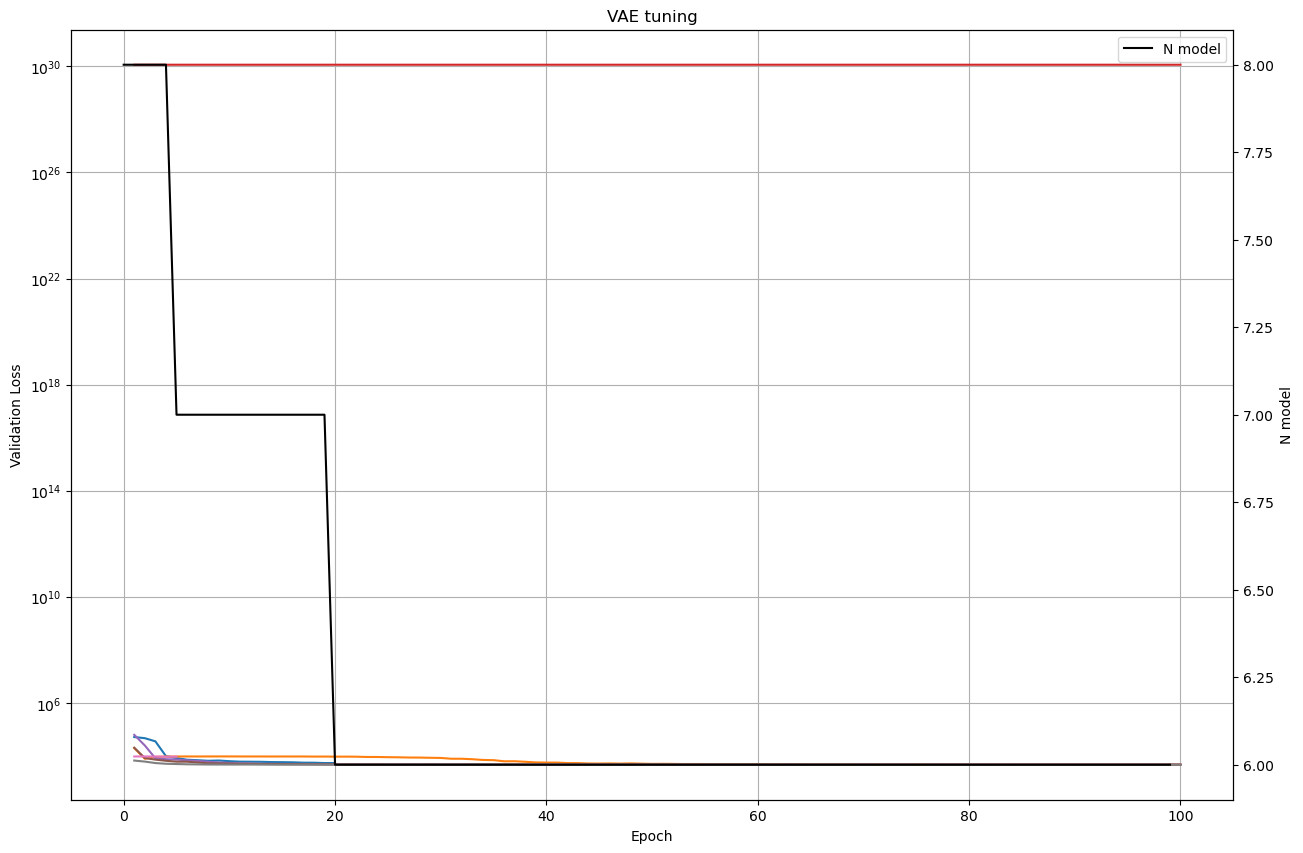

In [ ]:
# show results
dfs = {result.path: result.metrics_dataframe for result in results}

# twinx plot alive_model and validation loss
fig, ax1 = plt.subplots(figsize=(15, 10))
# plot the validation loss
for path, df in dfs.items():
    ax1.plot(df["training_iteration"], df["loss"], label=path)
ax1.set_yscale("log")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Validation Loss")
ax1.grid()

# plot the alive model
ax2 = ax1.twinx()
ax2.plot(alive_model, label="N model", color="black")
ax2.set_ylabel("N model")
ax2.legend()
ax2.grid()

plt.title("VAE tuning")
plt.grid()

# save the plot
plt.savefig("results/alive_model.png")

In [ ]:
# get best model
best_result = results.get_best_result("loss", mode="min")
logdir = best_result.path
state_dict = torch.load(os.path.join(logdir, "model.pth"))
best_model = VAE(n_conv=best_result.config["n_conv"], n_hidden=best_result.config["n_hidden"], n_dense=best_result.config["n_dense"], latent_dim=best_result.config["latent_dim"])

best_model.load_state_dict(state_dict)

# save best model
torch.save(best_model, "models/Emulator_tuned.pt")